# Illumination Problem
This problem is discussed in cvx_books_slides.pdf, lecture 1, pages 9-11. Consider $m$ fixed lamps illuminating $n$ small and flat patches in a 2-d space, 
![figure](imgs/ilumination.png)

Moreover, the ilumination intensity $I_k$ in a patch $k$ depends linearly on lamp powers $p_j$,
\begin{align}
I_k = \sum_{j=1}^m a_{kj}p_j, \quad a_{kj} = r_{k,j}^{-2}~max(cos~\theta_{kj}, 0)
\end{align}
where $r_{kj}$ is the distance between the patch $k$ and lamp $j$, and $\theta_{kj}$ is the angle between $r_kj$ and the normal vector to the patch surface $k$. **The goal is to choose the bounded lamps power $p_j$ in order to achieve a desired illumination $I_{des}$**. 


## Problem data

* There are 10 lamps ($m = 10$) and 20 patches ($n = 20$).
* $p \in \mathbb{R}^m$ is our problem variables, where $p_j$ is the power of lamp $j$.
* Let's consider the matrix $A \in \mathbb{R}^{n \times m}$ where $A_{ij}$ defines the incidence ($a_{ij}$) of lamp $j$ on patch $i$. The matrix A is stored in the data/illum_data.csv.
* We take $I_{des}=1$ and $p_{max}=1$. 

In [105]:
# Import libraries
%matplotlib inline
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import matplotlib.pyplot as plt
from cvxpy import *


# Load Data
A = np.loadtxt('./data/illum_data.csv', delimiter=',')
n, m = A.shape
Ides = 1
pmax = 1

print("A defines the geometry for n={} patches and m={} lamps".format(n,m))

A defines the geometry for n=20 patches and m=10 lamps


## Problem Description

We can express the general illumination problem as,
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \text{max}_{k=1,\ldots,n} \mid log~I_k - log~I_{des}\mid \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}

Our data, however, allows simplifications of the objective $f_0(\dot) $ of our problem,

\begin{equation*}
\begin{aligned}
f_0(p) &= \text{max}_{k=1,\ldots,n} \mid log~I_k - log~I_{des}\mid & (log~I_{des} = log~1 = 0)\\
& = \text{max}_{k=1,\ldots,n} \mid log~I_k\mid  & (\mid log~I_{des} \mid = log~I_{des}~\text{or}~-log~I_{des} = log~I_{des}^{-1})\\
& = \text{max}_{k=1,\ldots,n} \text{max} \left\{ log~I_k, log~(1 / I_k) \right\} & (\text{log function is monotonically increasing})\\
& = log~\text{max}_{k=1,\ldots,n} \text{max} \left\{ I_k, (1 / I_k) \right\} & 
\end{aligned}
\end{equation*}

Then our problem can be described as,
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & log~\text{max}_{k=1,\ldots,n} \text{max} \left\{ I_k, (1 / I_k) \right\} \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}
which is a convex optimizations problem, since logarithm is a monotonically increasing function and we are minimizing a pointwise maximum of linear functions. 

Therefore, we will compute several approximate solutions, and compare the results to the exact solution, for our specific problem instance.


### Approximate solutions:

#### 1 - Use uniform power 
Take $p_j = \lambda$ for $j = 1,\ldots,m$, vary $\lambda \in [0, p_{max}]$ and compute $f_0(p)$. Then, pick the $\lambda$ as the one which gives the smallest value of $f_0(p)$.

Best solution p* = [ 0.36  0.36  0.36  0.36  0.36  0.36  0.36  0.36  0.36  0.36]
Best objective f0* = 0.50


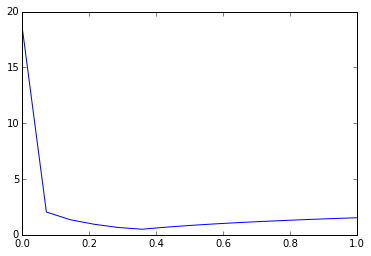

In [191]:
# The maximum difference to the desired ilumination
def objective(p):
    return np.max(np.abs(np.log(np.dot(A,p) + 1e-8)), axis=0)

num_vals = 15
lamb = np.linspace(0, pmax, num=num_vals)
ps = np.dot(np.ones((m,1)), lamb.reshape(1, num_vals))
f0s = objective(ps)
plt.plot(lamb, f0s)
idx = np.argmin(f0s)
p_uni = np.ones(m) * lamb[idx]
f0_uni = f0s[idx]
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_uni, f0_uni))

#### 2 -  Least-squares with saturations: 
solve the least-squares problem, (i.e., $\text{minimize}~\mid\mid Ap - I_{des}\mid\mid^2_2$) and clip the solution $p_j$ values between $[0,p_{max}]$. 

In [189]:
p_ls, _, _, _ = np.linalg.lstsq(A, np.ones(n)*Ides)
p_ls = np.clip(p_ls, 0, pmax)
f0_ls = objective(p_ls)
print("Best solution p*={}\nBest objective f0*={:.2f}".format(p_ls, f0_ls))

Best solution p*=[ 1.  0.  1.  0.  0.  1.  0.  1.  0.  1.]
Best objective f0*=0.86


#### 3 - Regularized least-squares: 
Solve regularized least-sqaures problems (i.e., $\text{minimize}~\mid\mid Ap - I_{des}\mid\mid^2_2 + \lambda \mid\mid p - 0.5p_{max} \mid\mid^2_2$) increasing the value of $\lambda \geq 0$ until the solution $p$ values are in the interval $[0, p_{max}]$.

In [188]:
lambs = np.linspace(1e-3, 1, num=15);
ps, norms = [], []
for lamb in lambs: 
    cofs = np.vstack((A, np.sqrt(lamb)*np.eye(m)))
    tgs = np.vstack((np.ones((n,1))*Ides, np.sqrt(lamb)*0.5*np.ones((m,1))*pmax))
    p, _, _, _ = np.linalg.lstsq(cofs, tgs)
    ps.append(p.ravel())
    norms.append(np.linalg.norm(p.ravel() - 0.5, ord=np.inf))
ps = np.array(ps)
norms = np.array(norms)
idx = np.where(norms <= 0.5)[0][0]
p_rls = ps[idx]
f0_rls = objective(p_rls)
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_rls, f0_rls))

Best solution p* = [ 0.48  0.46  0.08  0.04  0.44  0.43  0.45  0.43  0.4   0.45]
Best objective f0* = 0.45


#### 4 - Chebyshev approximation: 
Solve the problem, 
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \text{max}_{k=1,\ldots,n} \mid I_k - I_{des}\mid \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}

We can think of this problem as obtained by approximating the nonlinear function $f_0$ by a piecewise-linear function.

In [187]:
p = Variable(m)
obj = Minimize(norm(A*p - Ides, 'inf'))
const = [p >= 0, p <= pmax]
prob = Problem(obj, const)
prob.solve()  

p_ch = np.ravel(p.value)
f0_ch = objective(p_ch)
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_ch, f0_ch))

Best solution p* = [ 1.    0.12  0.    0.    1.    0.    1.    0.02  0.    1.  ]
Best objective f0* = 0.42


### Exact solutions
Solve the problem,

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & log~\text{max}_{k=1,\ldots,n} \text{max} \left\{ I_k, (1 / I_k) \right\} \\
& \text{subject to}
& & 0 \leq p_j \leq p_{max},~j=1,\ldots,m\\
\end{aligned}
\end{equation*}

In [186]:
p = Variable(m)
obj = Minimize(max_entries(max_elemwise(A*p , inv_pos(A*p))))
const = [p >= 0, p <= pmax]
prob = Problem(obj, const)
prob.solve()  

p_ex = np.ravel(p.value)
f0_ex = objective(p_ex)
print("Best solution p* = {}\nBest objective f0* = {:.2f}".format(p_ex, f0_ex))


Best solution p* = [ 1.    0.2   0.    0.    1.    0.    1.    0.19  0.    1.  ]
Best objective f0* = 0.36


### Results

The exact solution reaches the smallest objective which measures how close we are to the desired illumination $I_des$. The results are summarized in the following table,

In [192]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

index = ['f0(p)']
index.extend(["p{}".format(i) for i in range(m)])

d = {'Uniform' : pd.Series([f0_uni] + p_uni.tolist(), index=index),
    'Least-Square' : pd.Series([f0_ls] + p_ls.tolist(), index=index),
    'Reg-Least-Square' : pd.Series([f0_rls] + p_rls.tolist(), index=index),
    'Chebyshev' : pd.Series([f0_ch] + p_ch.tolist(), index=index),
    'Exact' : pd.Series([f0_ex] + p_ex.tolist(), index=index)
    }
df = pd.DataFrame(d)
df

,Chebyshev,Exact,Least-Square,Reg-Least-Square,Uniform
f0(p),0.420,0.357,0.863,0.446,0.501
p0,1.000,1.000,1.000,0.476,0.357
p1,0.116,0.202,0.000,0.455,0.357
p2,0.000,0.000,1.000,0.080,0.357
p3,0.000,0.000,0.000,0.038,0.357
p4,1.000,1.000,0.000,0.444,0.357
p5,0.000,0.000,1.000,0.427,0.357
p6,1.000,1.000,0.000,0.450,0.357
p7,0.025,0.188,1.000,0.426,0.357
p8,0.000,0.000,0.000,0.404,0.357
